---
layout:code-post
title: Shallow Neural Nets and Activation Functions
tags: neural nets
---

In this post / notebook I'm going to move from a single neuron to a small
network of neurons, demonstrating just a bit how the complexity increases.
We won't actually train anything in this notebook, we'll just be playing
around with the expressive power of shallow neural networks and
looking at a few of the common activation functions.

Outline:

1. Adding neurons
2. Activation Functions
  * Sign function
  * Sigmoid
  * ReLU
3. General setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Functions for lines
class SlopeLine():
    """ a line defined by slope and intercept """
    def __init__(self, m, b):
        self.m = m
        self.b = b
        
    def y(self, x):
        return self.m * x + self.b
    
    def x(self, y):
        return (y - self.b) / self.m

def get_slope_line(point_1, point_2):
    """returns slope line object with line determined by the points
    where point_i = (x, y)"""
    
    m = (point_2[1] - point_1[1]) / (point_2[0] - point_1[0])
    b = point_1[1] - m * point_1[0]
    
    return SlopeLine(m, b)

## 2. Adding Neurons

A single neuron $v_1$ acts on $k$-dimensional input $x$ by weighting each
component of $x$ as well as the constant 1, adding these weighted
components together, and inputing that into an activation function
$\sigma$. If we write the input as $x' = (x, 1)$ as a column vector,
then the input $a$ to the neuron is $Wx'=a$ where $W$ is an $(k+1)$-dimensional
row vector, i.e., a $1,k+1$-dimensional matrix. Then the output $o$ of the
neuron is $o=\sigma(Wx')$.

Let's add a second neuron $v_2$. It also gets the same input but with
different weights. If we take $W$ to be a $2,k+1$-dimensional matrix,
then $Wx'$ is length 2 vector. Let's now regard $\sigma$ as a function 
which applies the previous activation function to each component of an 
input vector. Then the output of the two neurons is $\sigma(Wx')$, as
before, but we've changed the meaning of the components.

However, we have a problem. We now have two dimensional output when we
are predicting one class. We then add an _output layer_ which consists
of a single neuron that takes in the weighted output of the previous
layer and applies an activation function. So by trying to expand our
neural network from 1 neuron to 2, we naturally were forced to add a
single neuron output layer as well as weights for the outputs of each
of the two neurons. If we consider the inputs as a layer, we
see the the simplest neural network that does not reduce to a single neuron
has one _hidden layer_ of two neurons, an output layer of a single neuron,
and $k+1$ trivial neurons in the _input layer_.

We will write $W^1$ for the $2,k-1$-dimensional weight matrix
from $x'$ to the hidden layer, and $W^2$ for the $1,2$-dimensional
weight matrix (in this case a vector) for the weights going to the output
layer from the hidden layer. The output of the neural network is
$\sigma(W^2\sigma(W^1x'))$. Note that we could change the activation
functions per neuron or per level. In particular, the output layer
might have a distinct activation function from the hidden layers.

Let's set up this simple neural network and see what it can do.

In [3]:
class SimpleNN():
    """neural network with n hidden layers"""
    
    def __init__(self, w, sigma):
        self.w = w
        self.sigma = sigma
        self.o = [0 for i in range(len(self.w))]
        
    def output(self, x):
        """ we assume that the row vector x already has 1 appended to it"""
        if type(x) == list:
            x = np.array(x)
            
        # this is not optimal programming... but it does say simple nn
        self.o[0] = self.sigma[0](np.matmul(self.w[0], x.transpose()))
        
        for i in range(1, len(self.o)):
            self.o[i] = self.sigma[i](np.matmul(self.w[i], self.o[i-1]))
        return self.o[-1].transpose()
    
def sigmoid(x):
    return 1.0/(1 + np.exp(-x))

## 3. Activation functions

### The sign function

In the [perceptron notebook](https://kevinnowland.com/code/2020/04/03/perceptron.html),
we saw how individual neurons act as linear separators. What happens if we 
have the two neurons in the activation layer act this way? To most closely
match the perceptron, we'll use the sign function as the activation function
for both the hidden layer and the output layer.

In this simple setup, we will write $v_1$ and $v_2$ for the two neurons
in the hidden layer, $o_i$ for each neurons output and $a_i$ for each
neurons input. We will stick with $x=(x_1, x_2, 1)$ as the overall input
to the network.

Let's write the input to the output neuron as
$w_1 o_1 + w_2 o_2$,
where $o_i$ is the output of $v_i$ in the hidden layer and the $w_i$
is the corresponding weight. We will assume that $|w_1|\neq|w_2|$, which,
given that we both randomly initialize and optimize these weights in
practice, is a safe assumption. Without loss of generality, let's
suppose $|w_1| < |w_2|$. In this case, the sign of $o_2$ will
always dominate, and we've reduced to the case of a single neuron.

For more interesting width two behavior, skip to section B below
where we use the sigmoid activation function in the hidden layer.

To keep with the sign function as the activation function, let's add a third
neuron to the hidden layer, $v_3$, which is not connected to the
inputs, and instead outputs $1$ at all times.

W^1 = 
 [[-0.69167432  0.48009939 -0.47336997]
 [ 0.06747879 -0.97085008  0.83749402]
 [ 0.          0.          0.        ]]
W^2 = 
 [[ 0.80142971 -0.93315714  0.91389867]]


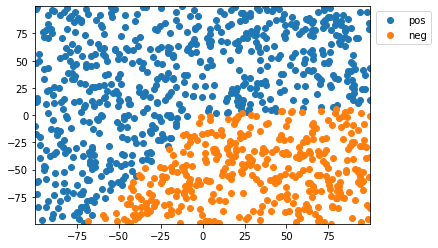

In [4]:
np.random.seed(12)


def sigma_constant(x):
    """ applies sign function on first n-1 terms
    of nx1 array, and returns 1 to the last term"""
    o_1 = x.copy()
    o_1[:-1,] = np.sign(o_1[:-1,])
    o_1[-1,] = o_1[-1,] + 1
    return o_1


# need a 3x3 matrix to feed the first layer
# need a 1x3 for the second layer
w = [
    np.zeros((3, 3))
    ,np.zeros((1, 3))
]

# initialize the non-zero weights
w[0][:2, :] = np.random.uniform(-1, 1, (2, 3))
w[1] = np.random.uniform(-1, 1, (1, 3))

print('W^1 = \n', w[0])
print('W^2 = \n', w[1])


snn = SimpleNN(w, [sigma_constant, np.sign])


# function to help plotting
def plot_neural_net_output(xlims, ylims, snn, ax=None):
    """output figure and axes of neural network predictions
    using the limits in xlims and ylims and neural net snn """
    
    # generate random points
    test_data = np.ones((1000, 3))
    test_data[:,0] = np.random.uniform(xlims[0], xlims[1], 1000)
    test_data[:,1] = np.random.uniform(ylims[0], ylims[1], 1000)

    # predict
    output = snn.output(test_data)

    df = pd.DataFrame({
        'x_1': test_data[:,0]
        ,'x_2': test_data[:,1]
        ,'y': output.flatten()
    })
    
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = None
    
    ax.set_xlim(df['x_1'].min(), df['x_1'].max())
    ax.set_ylim(df['x_2'].min(), df['x_2'].max())
    
    c = df.y == 1

    ax.plot(df[c].x_1, df[c].x_2, 'o', label='pos')
    ax.plot(df[~c].x_1, df[~c].x_2, 'o', label='neg')
    ax.legend(loc='upper center', bbox_to_anchor=(1.1, 1))
    
    return fig, ax

fig, ax = plot_neural_net_output([-100, 100], [-100, 100], snn)
plt.show()

Let's take a closer look at this picture.

The weigths in $W^1$ map show that $v_1$ receives the input $-0.69x_1 + 0.48x_2 - 0.47$ which is positive as long as
$x_2 > 1.44 x_1 + 0.98$. The nueron $v_2$ will put out a $+1$ as long as 
$x_2 < .06 x_1 + 0.86$. Let $o_i$ be the output of $v_i$. Then the input to the output neuron is
$ 0.80 o_1 - 0.933 o_2 + 0.91$. Note that this will be positive if either $o_1$ is positive or $o_2$ is negative.
Thus the $+1$ output of the neural network is the union of two planes 
given by $x_2 > 1.44 x_1 + 0.98$ and $x_2 > .06 x_1 + 0.86$.

However, if the output of the constant neuron $v_3$ was weighted by $-0.91$, the positive 
region would require $o_2$ to be negative and $o_1$ to be positive, such that the positive region would
be the intersection of two planes.

Both of these behaviors are possible since $|w_1| + |w_2| > |w_3|$ but $||w_1| - |w_2|| < |w_3|$.
Obviously if $|w_3|$ was larger than $|w_1|+|w_2|$ then output of the neural net would either
be entirely $+1$ or $-1$ corresponding to the sign of $w_3$. On the other hand,
if $||w_1|-|w_2|| > |w_3|$, then the behavior would be entirely governed by $w_1$ and $w_2$ and we 
would be in the trivial case described above.

In general, a width two neural network with $n+1$ neurons in the hidden layer, $n$ of which
have the sign function for their activators and the last putting out the constant $1$
can have $+1$ region that is either the intersection or union of $n$ planes.
Assuming all the weights $w_1,\ldots,w_n$ are $+1$, then the constant weight $w_{n+1}=-(n-1)$
works to force the intersection of the planes defined by the weights in $W^1$.
The union occurs by switching the sign of $w_{n+1}$.

One can add a third layer to combine the two situations. In the first layer, apply
weights to get a $+1$ above the line defined by the weights between the input 
and first hidden layer. Then, connect each of the plans to intersect or union to a neuron
in the second layer along with the output of a constant neuron weighted using the logic
above. To get the union of all these combinations of planes, combine the
output with another constant neuron going into the output layer with the output of
another constant neuron, again weighted as above.

For a simple example, let's get the union of the intersection of two regions
that are defined as being between parallel lines.

If we want to map above the line $y = mx+b$, then we need $y > mx + b$ 
in which case we need $y - mx - b > 0$ To be below, we need $-y + mx + b > 0$.

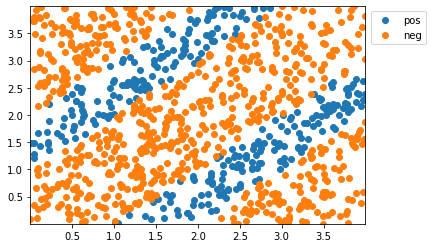

In [5]:
w = [
    np.zeros((5, 3)) # map (x_1,x_2,1) to 4 neurons in the hidden layer + 1 constant neuron
    ,np.zeros((3, 5)) # map the 5 output neurons to 2 neurons in the hidden layer + 1 constant neuron
    ,np.zeros((1, 3)) # map the three to 1
]

def get_line_weights(m, b, above):
    if above:
        return [-m, 1, -b]
    else:
        return [m, -1, b]

# map the lines
w[0] = np.array([
    get_line_weights(1, 2, False)
    ,get_line_weights(1, 1, True)
    ,get_line_weights(1, -1, False)
    ,get_line_weights(1, -2, True)
    ,[0, 0, 0]
])

# combine them
w[1] = np.array([
    [0.9, 0.9, 0, 0, -1]
    ,[0, 0, 0.9, 0.9, -1]
    ,[0, 0, 0, 0, 0]
])

w[2] = np.array([0.9, 0.9, 1])


snn_two_lines = SimpleNN(w, [sigma_constant, sigma_constant, np.sign])

fig, ax = plot_neural_net_output([0, 4], [0, 4], snn_two_lines)
plt.show()

Note that with two hidden layers we can provide an XOR gate. Here's an example
where the positive positive region cosists of the region above the line $y = 2x - 1$,

or below the line $y = 0.5x + 1$, but not both.


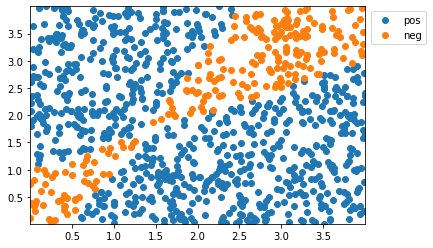

In [6]:
w = [
    np.zeros((3, 3))
    ,np.zeros((3, 3))
    ,np.zeros((1, 3))
]

def get_line_weights(m, b, above):
    if above:
        return [-m, 1, -b]
    else:
        return [m, -1, b]

# map the lines
w[0] = np.array([
    get_line_weights(2, -1, True)
    ,get_line_weights(0.5, 1, False)
    ,[0, 0, 0]
])

# combine them
w[1] = np.array([
    [0.9, 0.9, 1]
    ,[0.9, 0.9, -1]
    ,[0, 0, 0]
])

w[2] = np.array([0.9, -0.9, -1])


snn_xor = SimpleNN(w, [sigma_constant, sigma_constant, np.sign])

fig, ax = plot_neural_net_output([0, 4], [0, 4], snn_xor)
plt.show()

### The Sigmoid Function

Now let's change the hidden lyaer activation function to be the sigmoid
function 
$$ f(x) = \frac{1}{1 + \exp(-x)}. $$
The output layer will activate using the sign function. The sigmoid function is
a differentiable approxmation to the binary step function which is 0 for
all negative numbers and 1 otherwise.

W^1 = 
 [[ 0.93405968  0.0944645   0.94536872]
 [ 0.42963199  0.39545765 -0.56782101]]
W^2 = 
 [[ 0.95254891 -0.98753949]]


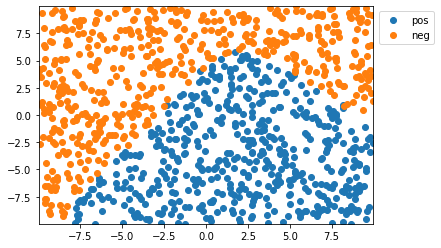

In [7]:
# instantiate neural network
np.random.seed(4)

w = [
    np.random.uniform(-1, 1, (2, 3))
    ,np.random.uniform(-1, 1, (1, 2))
]

print('W^1 = \n', w[0])
print('W^2 = \n', w[1])

snn_sigmoid = SimpleNN(w, [sigmoid, np.sign])

fig, ax = plot_neural_net_output([-10, 10], [-10, 10], snn_sigmoid)
plt.show()

The positive region appears to be bounded by two lines.

Let $o_1$ be the output of the first neuron in the hidden layer and $o_2$
the output of the second neuron. The output of the neural net is given 
by $\operatorname{sign}{(w_1o_1 + w_2o_2)}$, where we have suppressed the superscript
on the weights. Since $o_i = \sigma(a_i)$ and the sigmoid function is always
positive, if $w_1$ and $w_2$ have the same sign, then the output is determined
by this sign. Therefore we can assume that $w_1$ and $w_2$ have opposite signs.
We'll assume that $w_1>0$ and $w_2<0$.

Let's dispense with the degenerate case where $|w_1| = |w_2|$. In practice 
this will not happen, as we will be randomizing the weights and then 
optimizing, and both processes will ensure that this case does not occur. In
theory this is boring. The positive output case occurs then when $o_1 > o_2$ 
and the negative case when $o_1 < o_2$. Since the sigmoid function is 
increasing and $o_i = \sigma(a_i)$ where $a_i$ is the input to neuron $i$, 
this just says we care about $a_1 > a_2$ or vice versa. We might as well have 
replaced the sigmoid function with the identity function as the hidden layer 
activator.

With that taken care of, let's suppose that $|w_1| < |w_2|$ and $w_1 > 0$ while
$w_2 < 0$, which is the case for the picture generated above.
As a reminder, we are looking at the sign of $w_1 o_1 + w_2 o_2$. The dividing line
is $w_1 o_1 + w_2 o_2 = 0$. We can rewrite this as
$$ \left|\frac{w_2}{w_1}\right| = \frac{o_1}{o_2}. $$
Let's like $k = |w_2/w_1| > 1$. Plugging in $o_i = (1 + \exp(-a_i))^{-1}$
and solving for $e^{-a_2}$, one finds that 
$$ e^{-a_2} = ke^{-a_1} + (k-1), $$
such that in $(e^{-a_1}, e^{-a_2})$-coordinates, we have a line with slope
$k>1$ and intercept $k-1>0$. 

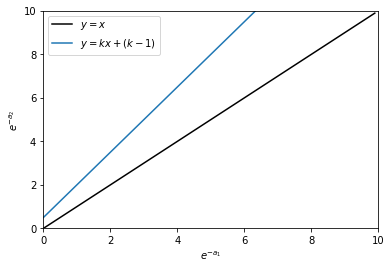

In [8]:
k = 1.5

fig, ax = plt.subplots()

ax.set_xlabel('$e^{-a_1}$')
ax.set_ylabel('$e^{-a_2}$')

ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

x = np.array([i/10.0 for i in range(100)])
y = k * x + (k-1)

ax.plot(x, x, color="black", label="$y=x$")
ax.plot(x, y, label="$y = kx + (k-1)$")

ax.legend()

plt.show()

Now let's consider what happens in terms of $(a_1, a_2)$. The $y$-intercept
at $k-1$ implies that the graph in $a$-coordinates has a horizontal asymptote
at $-\log(k-1)$, since $e^{-a_1}$ going to zero implies $a_1$ is going to 
positive infinity and $e^{-a_2}$ is going to the constant $k-1$.

On the other hand, when $a_1=0$, then we have $e^{-a_2} = 2k - 1$, such that
there is always a $a_2$-intercept at $-\log(2k - 1)$. Note that this is always
below the horizontal asymptote.

What about the behavior as $a_1$ tends to $-\infty$? If we rewrite the 
linear equation as
$$ \frac{e^{-a_2}}{e^{-a_1}} = k + \frac{k-1}{e^{-a_1}}, $$
we see that $e^{-a_2} \approx ke^{-a_1}$, such that
$a_2 \approx a_1 - \log k$.

Therefore our first approximation of the boundary between the
positive and negative regions can be described by 
$$
    a_2 = 
    \begin{cases}
        a_1 - \log k & a_1 < \log\left(\frac{k}{k-1}\right), \\
        -\log(k-1) & a_1 \geq \log\left(\frac{k}{k-1}\right).
    \end{cases}
$$
Above this line, the output of the neural net will be $-1$, while below it
the ouput will (mostly) be $+1$.

Now, for our situation we have
$$ a_1 \approx 0.934x_1 + 0.094 x_2 + 0.945, \quad  a_2 \approx 0.429x_1 + 0.395 x_2 -0.567, $$
with $k \approx 1.036$
Such that the lines we care about in $(x_1, x_2)$-coordinates are given by are
$$
    x_2 \approx 1.675 x_1 + 4.907,\quad x_2 \approx -1.086 x_1 + 9.790.
$$
Adding these lines to the plot we see that for a first approximation this is
not too terrible. The end behavior is well-captured, but the the meeting
between the two lines is off, as expected.

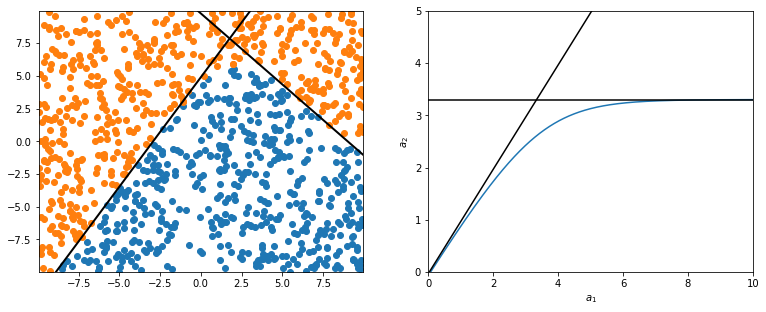

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))
lims = np.array([-10, 10])

_, ax[0] = plot_neural_net_output(lims, lims, snn_sigmoid, ax[0])

line_1 = SlopeLine(1.675, 4.907)
line_2 = SlopeLine(-1.086, 9.790)

ax[0].plot(lims, line_1.y(lims), color='black', linewidth=2)
ax[0].plot(lims, line_2.y(lims), color='black', linewidth=2)
ax[0].legend().remove()


xlims = np.array([0, 10])
ylims = np.array([0, 5])
ax[1].set_xlim(xlims)
ax[1].set_ylim(ylims)
ax[1].set_xlabel('$a_1$')
ax[1].set_ylabel('$a_2$')

k = np.abs(w[1][0, 1] / w[1][0, 0])

x = np.linspace(xlims[0], xlims[1], 1000)
y = -np.log(k * np.exp(-x) + k-1)
ax[1].plot(x, y)

line_1 = SlopeLine(1, -np.log(k))
line_2 = SlopeLine(0, -np.log(k-1))
ax[1].plot(xlims, line_1.y(xlims), color='black', linewidth=1.5)
ax[1].plot(xlims, line_2.y(xlims), color='black', linewidth=1.5)

plt.show()

The transition zone between the two behavior causes problems. 
All we have done so far is taken the tangent lines out at $\pm\infty$
in the $(a_1, a_2)$-plane, so of course adding more tangent lines will
improve the approximation.

Extremely naively, we see the approximation go from slop 1 to slope 0,
so maybe we find a tangent line with slope 1/2?

$$
\begin{align*}
    &\frac{d}{da_1}\left\{-\log(ke^{-a_1}+k-1)\right\} = \frac{1}{2} \\
    &\Rightarrow\quad \frac{k}{(k-1)e^x + k} = \frac{1}{2} \\
    &\Rightarrow\quad k = \log\left(\frac{k}{k-1}\right).
\end{align*}
$$
Therefore the point on the curve is $(\log\frac{k}{k-1},\log\frac{1}{2(k-1)})$. The
tangent line is given by
$$
    a_2 = \frac{1}{2}a_1 + \frac{1}{2}\log\left(\frac{1}{4k(k-1)}\right).
$$
Tranlsating to $(x_1, x_2)$-coordinates gives
$$
    x_2 \approx 0.107 x_1 + 5.689.
$$

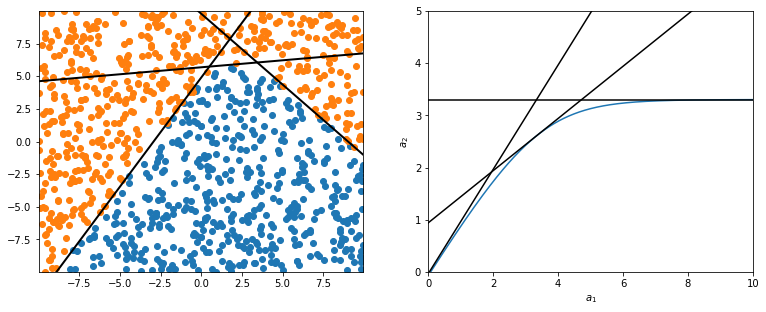

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))
lims = np.array([-10, 10])

_, ax[0] = plot_neural_net_output(lims, lims, snn_sigmoid, ax[0])

line_1 = SlopeLine(1.675, 4.907)
line_2 = SlopeLine(-1.086, 9.790)
line_3 = SlopeLine(0.107, 5.689)

ax[0].plot(lims, line_1.y(lims), color='black', linewidth=2)
ax[0].plot(lims, line_2.y(lims), color='black', linewidth=2)
ax[0].plot(lims, line_3.y(lims), color='black', linewidth=2)
ax[0].legend().remove()


xlims = np.array([0, 10])
ylims = np.array([0, 5])
ax[1].set_xlim(xlims)
ax[1].set_ylim(ylims)
ax[1].set_xlabel('$a_1$')
ax[1].set_ylabel('$a_2$')

k = np.abs(w[1][0, 1] / w[1][0, 0])

x = np.linspace(xlims[0], xlims[1], 1000)
y = -np.log(k * np.exp(-x) + k-1)
ax[1].plot(x, y)

line_1 = SlopeLine(1, -np.log(k))
line_2 = SlopeLine(0, -np.log(k-1))
line_3 = SlopeLine(0.5, 0.5*np.log(1/(4 * k * (k-1))))
ax[1].plot(xlims, line_1.y(xlims), color='black', linewidth=1.5)
ax[1].plot(xlims, line_2.y(xlims), color='black', linewidth=1.5)
ax[1].plot(xlims, line_3.y(xlims), color='black', linewidth=1.5)

plt.show()

Perhaps a more geometric idea would be to find the tangent line at
the point of maximum curvature of $a_2 = -\log(k e^{-a_1} + k-1)$. 
In other words, the point where $a_2'''=0$. It turns out that this
occurs at $a_2 = \log\frac{k}{k-1}$, and we would use the same tangent
line we found above.

Note that the second derivative is 
$$
    \frac{d^2}{da_1^2}\left\{-\log(ke^{-a_1}+k-1)\right\} = -\frac{(k-1)ke^x}{((k-1)e^x + k)^2}
$$
sucht that the maximum curvature is $1/4$. Note that this is independent of $k$.

In fact, let's write
$$
\begin{align*}
    a_2 &= -\log(k e^{-a_2} + k-1) \\
    &= -\log\left(k e^{-a_2 - \log\frac{k-1}{k} + \log\frac{k-1}{k}}+ k-1\right) \\
    &= -\log(e^{-a_2 - \log\frac{k-1}{k}} + 1) - \log(k-1).
\end{align*}
$$
Therefore the parameter $k$ takes the curve $y = -\log(e^{-x}+1)$ and shifts the $x$
coordinated by $x\mapsto x + \log\frac{k}{k-1}$ then shifts the function down by
$-\log(k-1)$. The actual shape of the curve does not change based on $k$, just its
location.

Since the inputs $(a_1, a_2)$ are already affine linearly transformed versions of the
neural network input $(x_1, x_2)$, the parameter $k$ is not important. All of the
degrees of freedom are tied up in the weights from the input to the first hidden layer
and the choice of which of the weights to the input layer are bigger, the positive
or negative weight, corresponding to the $+1$ output region being above or
below the curve in the $(a_1, a_2)$-plane.

### ReLU Function

The rectified linear unit function, commonly called the ReLU (ray-lou), function,
is the function $y = \max\{0, x\}$. In contrast to the sign function, it is
continuous, not just piece-wise linear. In contrast to the sigmoid function,
it is also convex, although it is not differentiable at $x=0$. Obviously it
cannot be considered as an approximation to the binary step function, either.
If the ReLU function is applied a difference $a-b$ of two numbers, note that
it preserves the difference if it is positive, but zeros out the difference
if $a-b$ is negative.

The hidden layer ReLU activators all put out zero, then the sign function
will be zero. Since we are only considering $\pm1$ as valid labels, let's
define the output to the $-1$ in this case.

Just as with the previous two activation functions, we'll start by
examining a neural network with two neurons in the sole hidden layer. Note
that if $w_1$ and $w_2$, the weights from the hidden neurons to the 
output layer, share the same sign, then the behavior is simple to determine.
If the weights are negative, the output will always be $+1$. If the 
weights are both positive, then output will be $+1$ except where both
$a_1$ and $a_2$ are negative.

Now suppose that $w_1>0$ and $w_2<0$. If both $a_1$ and $a_2$ are both positive,
the $+1$ region is given by $a_2 < \frac{w_1}{|w_2|}a_2$. Therefore the positive
region will be a half-plane in the first quadrant of the $(a_1,a_2)$-plane.
In the second quadrant where $a_1<0$ and $a_2>0$, the output will always be $-1$.'
In the third quadrant, the output will always be $-1$. And in the fourth
quadrant where $aa_1 > 0$ and $a_2 < 0$ the output will always be $+1$. Thus
in $(a_1, a_2)$-coordinates, the output will look like the following:

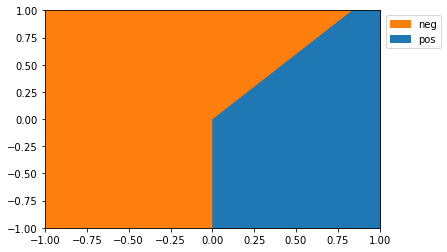

In [11]:
fig, ax = plt.subplots()

ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

ax.fill_between([-1, 1], [1, 1], [-1, -1], color='C1', label='neg')
ax.fill_between([0, 1], [0, 1.2], [-1, -1], color='C0', label='pos')

ax.legend(loc='upper center', bbox_to_anchor=(1.1, 1))

plt.show()

As stated above, the slope of the dividing line in the first quadrant
is $w_1/|w_2|$. The weights between the input layer and the hidden layer
act as an affine linear transformation between the region above in the
$(a_1, a_2)$-plane and the corresponding region in the $(x_1, x_2)$-plane.

Note that this wedge shape is not actually very different from the 
region defined by the sigmoid function given that rotations are linear
transformations. The main difference is the sharp point.

## 3. General Setup

Let $\ell_i$ consist of
a layer (list) of neurons $\{v_{i, 0}, \ldots, v_{i, n}\}$.

A feed forward neural network consists of layers of neurons $ell_i$ for 
$i=0, \ldots, T$ such that the neurons in $\ell_t$ feed into those in
$\ell_{t+1}$ only. By convention, if $x$ is $k$-dimensional input, then
$\ell_0$ consists of the $k+1$ neurons $n_i$ such that $n_i$ puts out $x_i$ for
$i=1,\ldots,k$ and $n_{k+1}$ outputs $1$. The $0$th layer is also called the
_input layer_.  The _output layer_ $\ell_T$ consists of a single 
neuron $v_T$ which aggregates the input from the previous layer into a final
prediction for the input data. The layers $\ell_1, \ldots, \ell_{T-1}$ are the
_hidden layers_. The _width_ of the network is th width of the widest
hidden layer.

Suppose that layer $\ell_{t-1}$ has width $n$ and $\ell_t$ has width $m$.
Let $o_{t-1}$ be the $n$-dimensional output of $\ell_{t-1}$ and let $a_t$
the $m$-dimensional input of $\ell_t$. If $w^t_{i, j}$ is the weight
from $v_{t-1, i}$ to $v_{t, j}$, then it follows that $W^t o_{t-1} = a_t$
where $W^t = (w^t_{i, j})$ is an $m\times n$-dimensional matrix. Two neurons
are not connected if the corresponding weight is 0.

Let $\sigma^t$ be the $m$-dimensional vector of activation functions for $\ell_t$.
Then $o_t = \sigma^t(a_t) = \sigma^t(W^to_{t-1})$.
If each component of each $\sigma^t$ is identical, we will just write $\sigma$
and the meaning will be clear from context.

Note that the smallest neural network which is not equivalent to a single
neuron has 1 hidden layer with 2 neurons. Considering the input layer
and the output layer, this neural network would have $k+4$ neurons:
$k+1$ in the input layer, $2$ in the single hidden layer, and 1 in the output
layer.

The _architecture_ of the network refers to the structure edges between neurons,
which are zero, and which are nonzero, as well as the which activation functions
each neuron has.

All of the above says that feed-forward neural networks work by alternately appying
affine linear transformations and activation functions. The linear transformations
need not be between spaces of the same dimension, and traditionally the
activation functions act coordinate-wise.